In [1]:
file_path1 = 'transaction_fraud_data.parquet'
file_path2 = 'historical_currency_exchange.parquet'

In [2]:
import pyarrow
import pandas
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df1 = pandas.read_parquet(file_path1)
df2 = pandas.read_parquet(file_path2)

In [4]:

df1['transaction_date'] = df1['timestamp'].dt.date  # Создаем новую колонку с датой

# Слияние данных
df = pandas.merge(
    left=df1,
    right=df2,
    left_on='transaction_date',
    right_on='date',
    how='left'
)

# Конвертация валют в USD
def convert_to_usd(row):
    if row['currency'] == 'USD':
        return row['amount']
    elif row['currency'] in df2.columns:
        return row['amount'] * row[row['currency']]
    else:
        return None  # Для неизвестных валют

df['amount_usd'] = df.apply(convert_to_usd, axis=1)

# Проверка конвертации
if df['amount_usd'].isnull().any():
    missing_currencies = df[df['amount_usd'].isnull()]['currency'].unique()
    print(f"Предупреждение: Нет курса для валют {missing_currencies}")
else:
    print("Все валюты успешно сконвертированы в USD!")

df.drop(columns=['transaction_date', 'date'], inplace=True, errors='ignore')


Все валюты успешно сконвертированы в USD!


In [5]:
fraud_ratio = df['is_fraud'].value_counts(normalize=True) * 100
print(f"Соотношение классов:\n{fraud_ratio}")



Соотношение классов:
is_fraud
False    80.027182
True     19.972818
Name: proportion, dtype: float64


In [6]:
plt.figure(figsize=(8, 6))
sns.countplot(x='is_fraud', data=df)
plt.title('Распределение мошеннических транзакций')
plt.savefig('fraud_distribution.png')  # Сохраняем в файл вместо отображения
plt.close()

In [7]:
activity_cols = ['num_transactions', 'total_amount', 'unique_merchants', 'unique_countries', 'max_single_amount']
for col in activity_cols:
    df[col] = df['last_hour_activity'].apply(lambda x: x[col])

# Корреляция активности с мошенничеством
activity_fraud_corr = df[activity_cols + ['is_fraud']].corr()['is_fraud'].sort_values(ascending=False)
print("\nКорреляция показателей активности с мошенничеством:")
display(activity_fraud_corr)

fraud_stats = df.groupby('is_fraud')['amount_usd'].agg(['mean', 'median', 'std', 'min', 'max'])
print("\nСтатистика сумм транзакций:")
print(fraud_stats)



Корреляция показателей активности с мошенничеством:


is_fraud             1.000000
max_single_amount    0.009226
unique_countries     0.009046
unique_merchants     0.006932
num_transactions     0.004506
total_amount         0.003332
Name: is_fraud, dtype: float64


Статистика сумм транзакций:
                  mean        median           std        min           max
is_fraud                                                                   
False     3.482932e+07   1158.120612  1.409786e+08  13.749450  2.061012e+09
True      1.544120e+08  71695.902142  5.687990e+08   0.007472  1.042450e+10


In [8]:
df['hour'] = df['timestamp'].dt.hour
df['day_of_week'] = df['timestamp'].dt.dayofweek
df['is_weekend'] = df['day_of_week'] >= 5

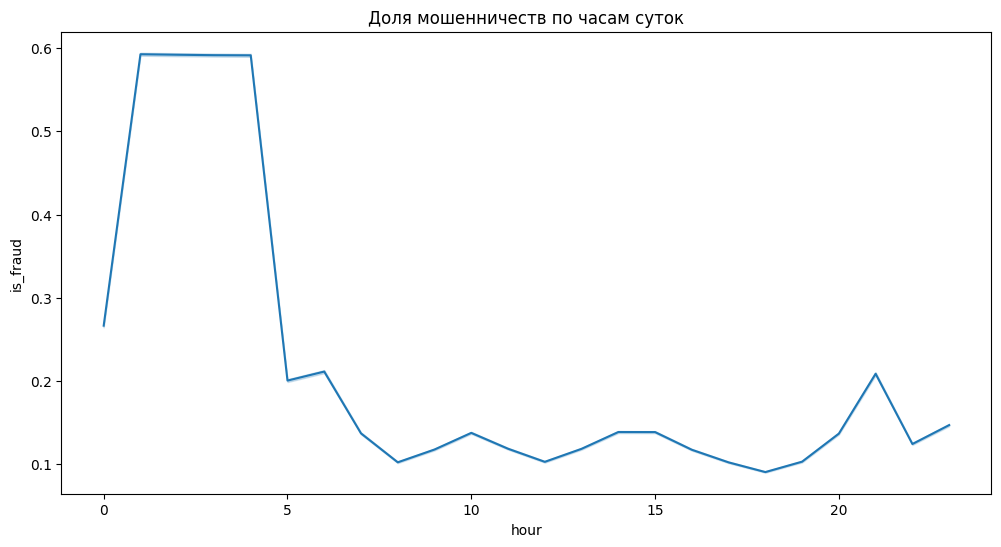

In [9]:
plt.figure(figsize=(12, 6))
sns.lineplot(x='hour', y='is_fraud', data=df, estimator='mean')
plt.title('Доля мошенничеств по часам суток')
plt.show()
plt.savefig('time_fraud.png')  # Сохраняем в файл вместо отображения
plt.close()

In [10]:
min_tx_date = df['timestamp'].min().date()
max_tx_date = df['timestamp'].max().date()
min_ex_date = df2['date'].min()
max_ex_date = df2['date'].max()

print(f"\nПериод транзакций: {min_tx_date} - {max_tx_date}")
print(f"Период курсов:     {min_ex_date} - {max_ex_date}")

if min_tx_date < min_ex_date or max_tx_date > max_ex_date:
    print("Предупреждение: Не все транзакции имеют курсы валют!")


Период транзакций: 2024-09-30 - 2024-10-30
Период курсов:     2024-09-30 - 2024-10-30


In [11]:
vendor_risk = df.groupby('vendor_category')['is_fraud'].mean().sort_values(ascending=False)
print(f'Риск по категориям вендоров: {vendor_risk}' )

Риск по категориям вендоров: vendor_category
Travel           0.200341
Grocery          0.200194
Gas              0.199731
Restaurant       0.199696
Entertainment    0.199632
Education        0.199459
Retail           0.199398
Healthcare       0.199376
Name: is_fraud, dtype: float64


In [12]:
high_risk_vendors = df[df['is_fraud']].groupby('vendor')['transaction_id'].count().nlargest(10)
print(f'топ 10 рискованных вендоров: {high_risk_vendors}' )

топ 10 рискованных вендоров: vendor
Local Gas Station       31205
Truck Stop              31192
Chegg                   31171
University Bookstore    31136
Highway Gas Stop        31016
Barnes & Noble          30933
DuaneReade              23513
CVS Pharmacy            23508
Walmart Grocery         23475
Medical Center          23464
Name: transaction_id, dtype: int64


In [13]:
channel_risk = df.groupby('channel')['is_fraud'].mean()
print(f'Риски по каналам: {channel_risk}' )

Риски по каналам: channel
mobile    0.123878
pos       1.000000
web       0.123275
Name: is_fraud, dtype: float64


In [14]:
device_risk = df.groupby('device')['is_fraud'].mean().sort_values(ascending=False)
print(f'Риски по device: {device_risk}' )

Риски по device: device
Chip Reader        1.000000
Magnetic Stripe    1.000000
NFC Payment        1.000000
Firefox            0.126831
Safari             0.126204
Android App        0.125070
Chrome             0.123710
iOS App            0.122703
Edge               0.116753
Name: is_fraud, dtype: float64


In [15]:
fraud_activity = df[df['is_fraud']][activity_cols].mean()
legit_activity = df[~df['is_fraud']][activity_cols].mean()
print(f'Активность клиентов перед мошенничеством1: {fraud_activity}' )
print(f'Активность клиентов перед мошенничеством2: {legit_activity}')

Активность клиентов перед мошенничеством1: num_transactions     4.126705e+02
total_amount         2.015500e+07
unique_merchants     8.044512e+01
unique_countries     1.071000e+01
max_single_amount    1.752255e+06
dtype: float64
Активность клиентов перед мошенничеством2: num_transactions     4.082625e+02
total_amount         1.985784e+07
unique_merchants     7.991672e+01
unique_countries     1.065077e+01
max_single_amount    1.719987e+06
dtype: float64


In [16]:
country_risk = df.groupby('country')['is_fraud'].mean().sort_values(ascending=False).head(10)
print(f'Риск по странам топ 10: {country_risk}')

Риск по странам топ 10: country
Mexico       0.380348
Russia       0.377238
Brazil       0.371060
Nigeria      0.351360
Australia    0.075805
USA          0.074615
Japan        0.071279
Germany      0.070939
Canada       0.069988
UK           0.069351
Name: is_fraud, dtype: float64


In [17]:
outside_risk = df.groupby('is_outside_home_country')['is_fraud'].mean()
print(f'Риск вне страны: {outside_risk}' )

Риск вне страны: is_outside_home_country
False    0.024902
True     0.567753
Name: is_fraud, dtype: float64


In [18]:
plt.figure(figsize=(10, 6))
vendor_risk.head(5).plot(kind='bar', color='firebrick')
plt.title('Топ-5 рискованных категорий вендоров')
plt.ylabel('Доля мошеннических операций')
plt.xticks(rotation=45)
plt.tight_layout
plt.savefig('top5_risk_vendor.png')  # Сохраняем в файл вместо отображения
plt.close()

In [19]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='is_fraud', y='amount_usd', data=df[df['amount_usd'] < 500])
plt.title('Распределение сумм транзакций')
plt.xlabel('Мошенничество')
plt.ylabel('Сумма (USD)')
plt.savefig('sum_fraud_distribution.png')  # Сохраняем в файл вместо отображения
plt.close()

Анализ распределения транзакций по странам

In [47]:
country_analysis = df1.groupby('country').agg(
    total_transactions=('transaction_id', 'count'),
    fraud_transactions=('is_fraud', 'sum'),
    total_amount=('amount', 'sum'),
    fraud_amount=('amount', lambda x: x[df1['is_fraud']].sum())
).reset_index()
country_analysis

,country,total_transactions,fraud_transactions,total_amount,fraud_amount
0,Australia,496695,37652,3.932281e+08,5.771999e+07
1,Brazil,804800,298629,3.045654e+09,1.683434e+09
2,Canada,532632,37278,3.709919e+08,5.307206e+07
3,France,541287,37426,2.624897e+08,3.623452e+07
4,Germany,524464,37205,2.634927e+08,3.601963e+07
5,Japan,527393,37592,3.444445e+10,4.719137e+09
6,Mexico,785704,298841,1.192691e+10,6.767799e+09
7,Nigeria,849840,298600,2.619924e+11,1.387288e+11
8,Russia,793730,299425,4.497373e+10,2.532112e+10
9,Singapore,588668,37414,4.742963e+08,5.708025e+07


Расчет дополнительных метрик

In [28]:
country_analysis['fraud_rate'] = country_analysis['fraud_transactions'] / country_analysis['total_transactions'] * 100
country_analysis['fraud_share'] = country_analysis['fraud_transactions'] / country_analysis['fraud_transactions'].sum() * 100
country_analysis['avg_fraud_amount'] = country_analysis['fraud_amount'] / country_analysis['fraud_transactions']

country_analysis

,country,total_transactions,fraud_transactions,total_amount,fraud_amount,fraud_rate,fraud_share,avg_fraud_amount
0,Australia,496695,37652,3.932281e+08,5.771999e+07,7.580507,2.519002,1532.985936
1,Brazil,804800,298629,3.045654e+09,1.683434e+09,37.105989,19.978939,5637.210293
2,Canada,532632,37278,3.709919e+08,5.307206e+07,6.998828,2.493980,1423.683233
3,France,541287,37426,2.624897e+08,3.623452e+07,6.914262,2.503882,968.164412
4,Germany,524464,37205,2.634927e+08,3.601963e+07,7.093909,2.489097,968.139622
5,Japan,527393,37592,3.444445e+10,4.719137e+09,7.127891,2.514988,125535.682956
6,Mexico,785704,298841,1.192691e+10,6.767799e+09,38.034807,19.993122,22646.823783
7,Nigeria,849840,298600,2.619924e+11,1.387288e+11,35.136026,19.976999,464597.597735
8,Russia,793730,299425,4.497373e+10,2.532112e+10,37.723785,20.032193,84565.827305
9,Singapore,588668,37414,4.742963e+08,5.708025e+07,6.355705,2.503079,1525.638798


Анализ для 4 целевых стран

In [29]:
target_countries = ['Mexico', 'Russia', 'Brazil', 'Nigeria']
target_analysis = country_analysis[country_analysis['country'].isin(target_countries)].copy()

target_analysis

,country,total_transactions,fraud_transactions,total_amount,fraud_amount,fraud_rate,fraud_share,avg_fraud_amount
1,Brazil,804800,298629,3.045654e+09,1.683434e+09,37.105989,19.978939,5637.210293
6,Mexico,785704,298841,1.192691e+10,6.767799e+09,38.034807,19.993122,22646.823783
7,Nigeria,849840,298600,2.619924e+11,1.387288e+11,35.136026,19.976999,464597.597735
8,Russia,793730,299425,4.497373e+10,2.532112e+10,37.723785,20.032193,84565.827305


Расчет потенциального эффекта от 2FA

In [30]:
target_analysis['prevented_fraud'] = target_analysis['fraud_transactions'] * 0.85
target_analysis['prevented_amount'] = target_analysis['fraud_amount'] * 0.85
target_analysis

,country,total_transactions,fraud_transactions,total_amount,fraud_amount,fraud_rate,fraud_share,avg_fraud_amount,prevented_fraud,prevented_amount
1,Brazil,804800,298629,3.045654e+09,1.683434e+09,37.105989,19.978939,5637.210293,253834.65,1.430919e+09
6,Mexico,785704,298841,1.192691e+10,6.767799e+09,38.034807,19.993122,22646.823783,254014.85,5.752630e+09
7,Nigeria,849840,298600,2.619924e+11,1.387288e+11,35.136026,19.976999,464597.597735,253810.00,1.179195e+11
8,Russia,793730,299425,4.497373e+10,2.532112e+10,37.723785,20.032193,84565.827305,254511.25,2.152295e+10


Визуализация результатов

In [26]:
plt.figure(figsize=(14, 10))

<Figure size 1400x1000 with 0 Axes>

<Figure size 1400x1000 with 0 Axes>

Распределение транзакций

Text(0, 0.5, '')

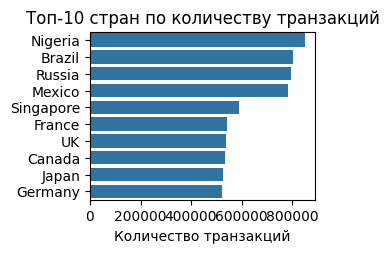

In [31]:
plt.subplot(2, 2, 1)
sns.barplot(x='total_transactions', y='country', data=country_analysis.nlargest(10, 'total_transactions'))
plt.title('Топ-10 стран по количеству транзакций')
plt.xlabel('Количество транзакций')
plt.ylabel('')

Доля мошенничества

Text(0, 0.5, '')

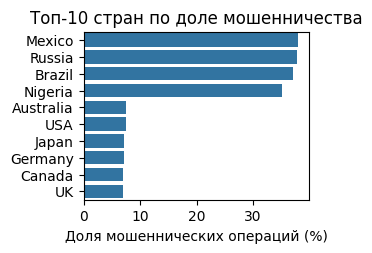

In [32]:
plt.subplot(2, 2, 2)
sns.barplot(x='fraud_rate', y='country', data=country_analysis.nlargest(10, 'fraud_rate'))
plt.title('Топ-10 стран по доле мошенничества')
plt.xlabel('Доля мошеннических операций (%)')
plt.ylabel('')

Финансовый риск

Text(0, 0.5, '')

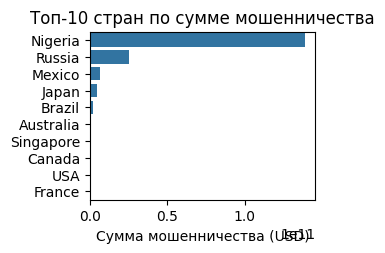

In [33]:
plt.subplot(2, 2, 3)
sns.barplot(x='fraud_amount', y='country', data=country_analysis.nlargest(10, 'fraud_amount'))
plt.title('Топ-10 стран по сумме мошенничества')
plt.xlabel('Сумма мошенничества (USD)')
plt.ylabel('')

Эффект от внедрения 2FA

Text(0, 0.5, '')

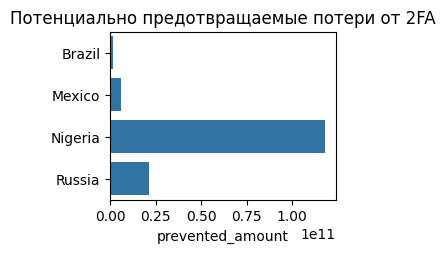

In [43]:
plt.subplot(2, 2, 4)
sns.barplot(x='prevented_amount', y='country', data=target_analysis)
plt.title('Потенциально предотвращаемые потери от 2FA')
# plt.xlabel('Предотвращаемая сумма (USD)')
plt.ylabel('')



In [36]:
plt.tight_layout()
plt.savefig('country_fraud_analysis.png')
plt.close()

Расчет ключевых метрик

total_fraud_amount = country_analysis['fraud_amount'].sum()
target_fraud_amount = target_analysis['fraud_amount'].sum()
prevented_amount_total = target_analysis['prevented_amount'].sum()

In [48]:
total_fraud_amount = country_analysis['fraud_amount'].sum()
target_fraud_amount = target_analysis['fraud_amount'].sum()
prevented_amount_total = target_analysis['prevented_amount'].sum()

In [49]:
metrics = {
    "Общая сумма мошенничества": total_fraud_amount,
    "Сумма мошенничества в 4 странах": target_fraud_amount,
    "Доля мошенничества в 4 странах": target_fraud_amount / total_fraud_amount * 100,
    "Потенциально предотвращаемые потери": prevented_amount_total,
    "Процент снижения потерь": prevented_amount_total / total_fraud_amount * 100,
    "Ожидаемое снижение мошенничества": target_analysis['prevented_fraud'].sum() / country_analysis['fraud_transactions'].sum() * 100
}

Сохранение результатов в DataFrame

In [50]:
metrics_df = pandas.DataFrame(list(metrics.items()), columns=['Metric', 'Value'])
print(metrics_df)

                                Metric         Value
0            Общая сумма мошенничества  1.775331e+11
1      Сумма мошенничества в 4 странах  1.725012e+11
2       Доля мошенничества в 4 странах  9.716563e+01
3  Потенциально предотвращаемые потери  1.466260e+11
4              Процент снижения потерь  8.259079e+01
5     Ожидаемое снижение мошенничества  6.798407e+01


Анализ ложных срабатываний

In [57]:
legit_in_target = df[(df['country'].isin(target_countries)) & (~df['is_fraud'])]
print(f"Количество легальных транзакций в целевых странах: {len(legit_in_target)}")
print(f"Доля от всех транзакций: {len(legit_in_target)/len(df)*100:.2f}%")

Количество легальных транзакций в целевых странах: 2038579
Доля от всех транзакций: 27.24%


Оценка нагрузки на клиентов

In [60]:
print(f"Процент клиентов, которых затронет 2FA: {legit_in_target['customer_id'].nunique()/df['customer_id'].nunique()*100:.2f}%")

Процент клиентов, которых затронет 2FA: 100.00%
